<a href="https://colab.research.google.com/github/cdr6934/MeTooClassifier/blob/main/MeToo_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Import

# Building a Classifer to Predicting Triggering or Uncurteous Speech
MSDS - 4/27/2024

[Github](https://github.com/cdr6934/MeTooClassifier)

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hatred-on-twitter-during-metoo-movement:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F757737%2F1308786%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T191613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6cf04a7d6952564ee65b3616d7c5e51ac5c955b503c22a691be22f94dcf10902532bcee7897edf8b0b2fcc3db9bf65e45ff97c4e419bdab50c14a8ca1b02216c94b011ee6fe30ba96381b7afd59adb2669d4d6de4250dd572f28fa2b35be6de473066703ca4f2a298363c6ca2d3e214aebdeb9894f91d361ec0fe3e563231f9e5bca2fc4b330d714d2726ee56a45d2408af64229ce380823b3274a0a421c73dc2dc4a99a69b3aee1a0c04f76cc48a499f3753491c52e523f3c5f3236e9f603282b86348be6edd60fc95a654568bada9b1bc6b9824a8e51b19cd5f94417e5427c1e0c36cdaf9e827722406e2f2fe0d8892b15eff603ab72b263eec1e5accc371b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 67698437 bytes downloaded
Downloaded and uncompressed: hatred-on-twitter-during-metoo-movement
Data source import complete.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
from tqdm import tqdm

# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter


## NLP Libraries
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop=set(stopwords.words('english'))

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

## NN Libraries (Keras)
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# Introduction / Problem
In this project, we are going to try to build a classifer that can categorize comments from Twitter posts that can be classified as triggering or sometimes just hateful.

A model like this can help automate targeted language that can do a few different things; it can help moderate a platform (particular with short form). It does become tricky as there are generational rubrick that would deem something that might be triggering or not. So a way one might be able to self moderate based on preference.

This could be something like a a `NSFW filter` where insensitive pictures are blurred out but is controlled by the user. This project is a start in building a mechanism that can be placed into the pipeline of a social media company to help provide this context.


## Data
The following data comes from a dataset on [Kaggle](https://www.kaggle.com/datasets/rahulgoel1106/hatred-on-twitter-during-metoo-movement). These were tweets that were collected back in 2018 and since have been categorized. There are 807,174 tweets in total. Since this is not the noraml Kaggle competitions we are going to need ot use the data to validate our own accuracy of the model. Thus we will split the training data and test data on an 80/20 split. This will give us good sampling of the information that we are about to see.

##

In [7]:
#Load the dataset
data=pd.read_csv('/input/hatred-on-twitter-during-metoo-movement/MeTooHate.csv')
data.head()

,status_id,text,created_at,favorite_count,retweet_count,location,followers_count,friends_count,statuses_count,category
0,1046207313588236290,"Entitled, obnoxious, defensive, lying weasel. ...",2018-09-30T01:17:15Z,5,1,"McAllen, TX",2253,2303,23856,0
1,1046207328113086464,Thank you and for what you did for the women...,2018-09-30T01:17:19Z,5,2,"Tampa, FL",2559,4989,19889,0
2,1046207329589493760,Knitting (s) &amp; getting ready for January 1...,2018-09-30T01:17:19Z,0,0,"St Cloud, MN",16,300,9,0
3,1046207341283168256,Yep just like triffeling women weaponized thei...,2018-09-30T01:17:22Z,1,0,flyover country,3573,3732,38361,1
4,1046207347016826880,"No, the President wants to end movement posin...",2018-09-30T01:17:23Z,0,0,World,294,312,7635,0


In [ ]:
neg_t = data[data['category'] == 1].head(10)['text']

for idx, i in enumerate(neg_t):
  print(f'{idx} - {i}')


0 - Yep just like triffeling women weaponized their poon!! Wonder if Kamala Harris ever extorted Willy Brown after throwing the poon on him, oh yeh, that how she got her first job me too is a JOKE! 
1 - Save it for Fox Fake News—watched by racists, bigots &amp; other women-hating sexists like yourself. GOP is the party of Putin &amp; the party of Hate—besides women, GOP hates all POC, immigrants, and all ppl not straight. You’re the party of the entitled lying whiny white men.
2 - As a white male in this  era I'm just scared that if I decide to rape or sexually assault a woman, it can be used against me years later. How am I supposed to ask a girl out?!
3 -   I heard that  received some Shush/Slush money to settle rape charges by her aide who said she just could not remember where or when. . .
4 -    If she hasn't, it's because of people like you shaming her! How dare you tell her how she is or should be feeling! That is why I HATE  the  movement. Along with all of the other movements!

# Exploratory Data Analysis - EDA

In order to understand this data, we will need ot create a corpus of this data. That way we can better know what we need.. The dataset has the following data:
* text - Includes the text tweet (you can see these tweets above)
* created_at - day the tweet was created
* favorite_count - how many people have liked the tweet
* retweet_count - how many people retweeted the tweet
* location - location from where the tweet was placed
* follower_count - account follower count
* friends_count  - account following count
* Statuses_count  - account total tweets created
* Category - is it a mean tweet

However we are only going to be interested in the text and category data. The rest we have left out simply for further investigation to be done.

## Comparing Character Counts between Civil vs Uncivil Tweets

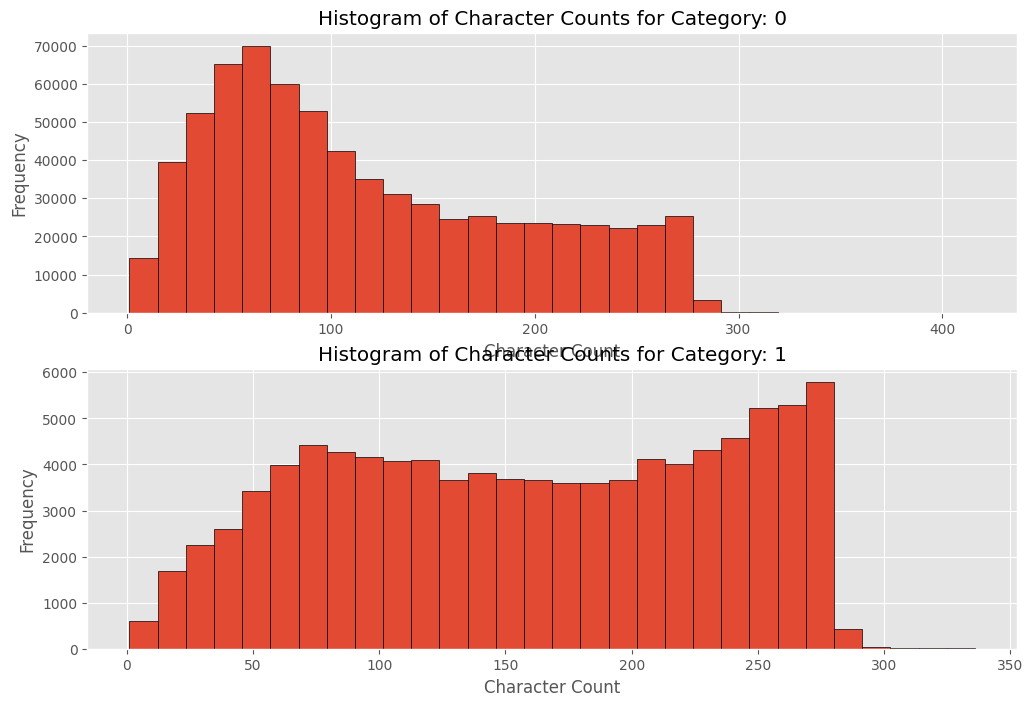

In [8]:
data['char_count'] = data['text'].str.len()

# Group data by 'category'
groups = data.groupby('category')

# Set up the plot for each group
num_categories = len(groups)
plt.figure(figsize=(12, 4 * num_categories))

for i, (name, group) in enumerate(groups, 1):
    plt.subplot(num_categories, 1, i)  # Create a subplot for each category
    plt.hist(group['char_count'], bins=30,  edgecolor='black')
    plt.title(f'Histogram of Character Counts for Category: {name}')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')



## Category Counts

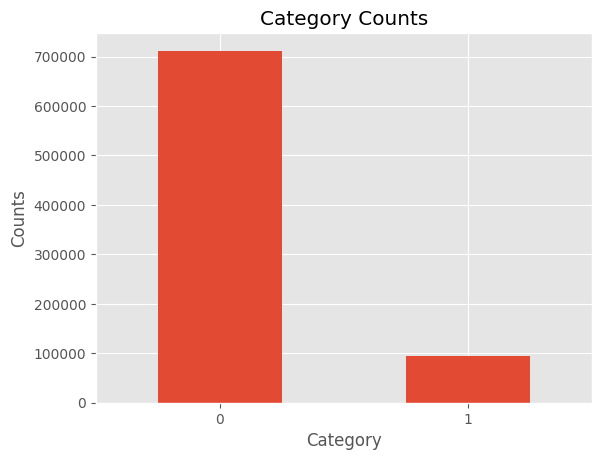

In [9]:
cat_count = data['category'].value_counts()
cat_count.plot(kind='bar')
plt.xlabel('Category')  # Set the x-axis label
plt.ylabel('Counts')    # Set the y-axis label
plt.title('Category Counts')  # Set the title
plt.xticks(rotation=0)  # Set the category names horizontal
plt.show()

This is a big indicator that shows that we need to rebalance the dataset in order to get better results. We will see that there is such a divide in the data due to the overindexing.

In [10]:
data['text'] = data['text'].map(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807174 entries, 0 to 807173
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status_id        807174 non-null  int64  
 1   text             807174 non-null  object 
 2   created_at       807174 non-null  object 
 3   favorite_count   807174 non-null  int64  
 4   retweet_count    807174 non-null  int64  
 5   location         616394 non-null  object 
 6   followers_count  807174 non-null  int64  
 7   friends_count    807174 non-null  int64  
 8   statuses_count   807174 non-null  int64  
 9   category         807174 non-null  int64  
 10  char_count       803638 non-null  float64
dtypes: float64(1), int64(7), object(3)
memory usage: 67.7+ MB


## Data Preprocessing

In [11]:
def remove_web_ref(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


#Remove emojis from the dataset
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove punctuation from the dataset
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

## Remove
data['text']=data['text'].apply(lambda x : remove_web_ref(x))
data['text']=data['text'].apply(lambda x: remove_emoji(x))
data['text']=data['text'].apply(lambda x : remove_punct(x))

In order to ensure that the data we recieve is more balanced, we have resampled. And thus have verified the information below. This is of course...

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
data = data.dropna()

X = data[['text']]
y = data['category']
# Define the strategy
rus = RandomUnderSampler(random_state=42)

# Fit and apply the transform
X_resampled, y_resampled = rus.fit_resample(X, y)


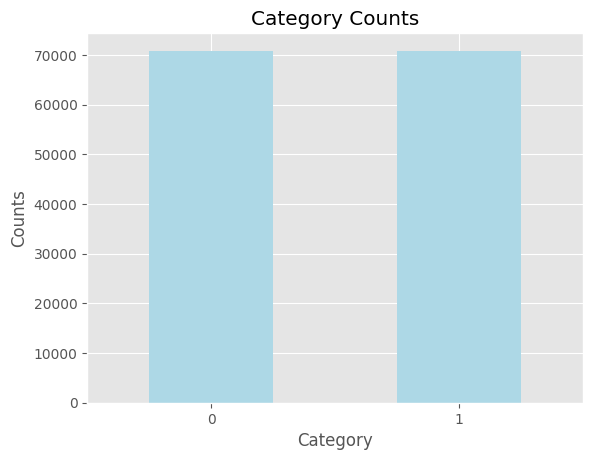

In [ ]:
cat_count = y_resampled.value_counts()
cat_count.plot(kind='bar',color='lightblue')
plt.xlabel('Category')  # Set the x-axis label
plt.ylabel('Counts')    # Set the y-axis label
plt.title('Category Counts')  # Set the title
plt.xticks(rotation=0)  # Set the category names horizontal
plt.show()

In [13]:
lemmatizer = WordNetLemmatizer()

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df):
        words = [word.lower() for word in word_tokenize(tweet) if word.isalpha()]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        filtered_words = [word for word in lemmatized_words if word not in stop]
        corpus.append(filtered_words)
    return corpus

corpus = create_corpus(X_resampled['text'])

100%|██████████| 141702/141702 [00:32<00:00, 4398.85it/s]


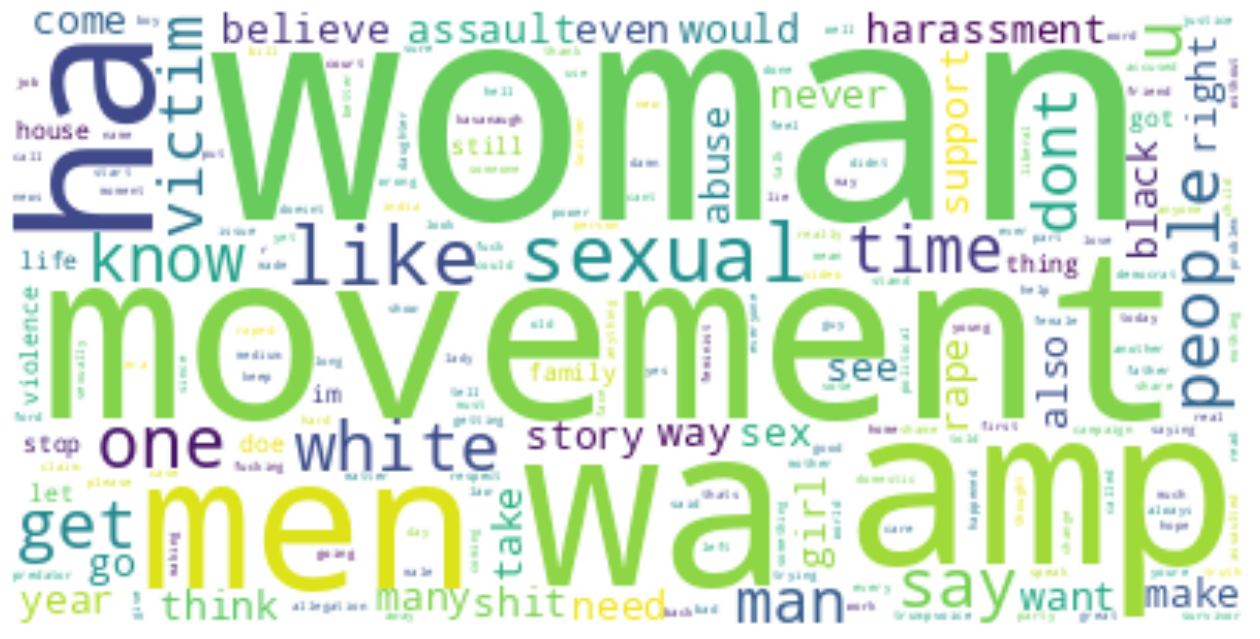

In [15]:

# Flatten the list of lists
flat_list = [word for sublist in corpus for word in sublist]

# Count the occurrences of each word
word_counts = Counter(flat_list)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_counts)

# Display the generated image:
plt.figure(figsize=(16, 16), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

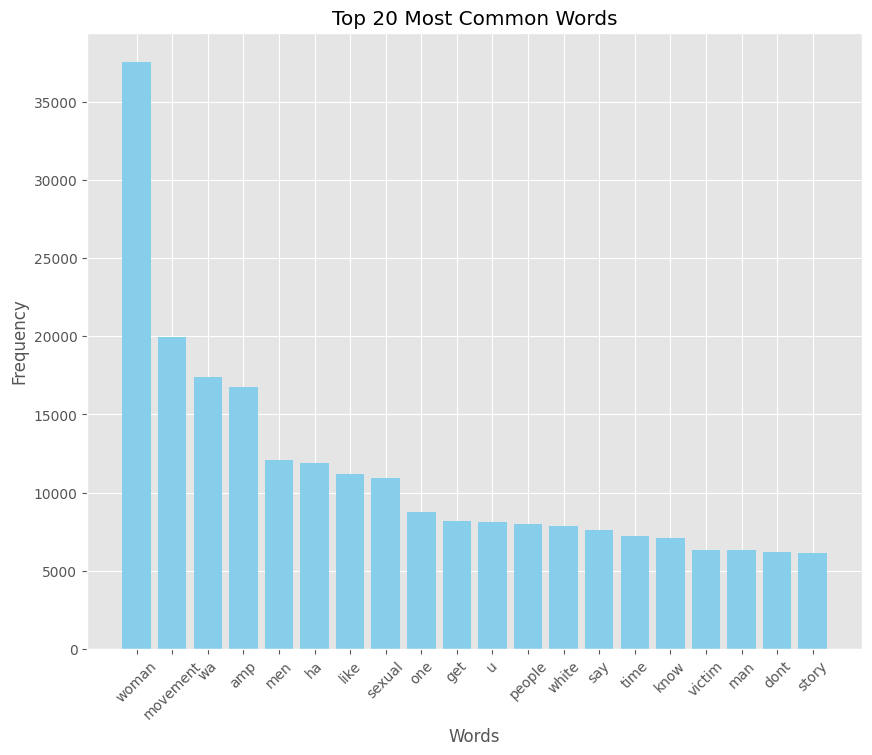

In [ ]:
# Unpack the words and their counts
top_20_words = word_counts.most_common(20)

words, counts = zip(*top_20_words)

# Create the bar chart
plt.figure(figsize=(10, 8))  # Set the figure size
plt.bar(words, counts, color='skyblue')  # Plot a bar chart
plt.xlabel('Words')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Top 20 Most Common Words')  # Title of the chart
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()  # Display the plot

As we can see from the word counts

# GloVe
GloVe, which stands for "Global Vectors for Word Representation," is a model for distributed word representation. The GloVe model is an unsupervised learning algorithm developed by researchers at Stanford for generating word embeddings by aggregating global word-word co-occurrence statistics from a corpus. The result is a set of vectors where each word is represented by a dense vector in a high-dimensional space. The vectors are designed such that their distance and direction encode meaningful linguistic relationships between words.

In [17]:
embedding_dict={}

with open('/content/drive/MyDrive/MSDS Deep Learning /glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [18]:
MAX_LEN=100
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [19]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 68568


In [20]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 68568/68568 [00:00<00:00, 550620.29it/s]


## Data Splitting

The first thing that we need to do is process the data so that we generate a more balanced dataset. In order to do this, we will start with under sampling the dataset.

In [21]:

X_subsample = X_resampled.sample(20000) # random selects 6400
sampled_indices = X_subsample.index

X_subsample=tweet_pad[sampled_indices]
y_subsample = y_resampled[sampled_indices]

# Sub-sample 10% of the training data
#X_subsample, _ = train_test_split(train, test_size=0.99, random_state=52)  # 10% to X_subsample, 90% to _
#y_subsample, _ = train_test_split(y_train, test_size=0.99, random_state=52)  # Corresponding targets


X_train, X_test, y_train, y_test = train_test_split(X_subsample, y_subsample, test_size=0.20, random_state=42)


# Model Architecture

We start out with a basic LSTM model that will help us understand where we might need to make further changes. First we run a baseline

### LSTM

Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) architecture that is particularly designed to handle sequence prediction problems. LSTMs are well-suited for classifying, processing, and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.

In [22]:
def lstm_model(lr = 0.0003, epoch = 32, dropout=0.2, batch=64):
  model=Sequential()
  embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,trainable=False)

  model.add(embedding)
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(64, dropout=dropout, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))


  optimzer=Adam(learning_rate=lr)

  model.compile(loss='binary_crossentropy',optimizer=optimzer, metrics=['accuracy'])

  history=model.fit(X_train,y_train,batch_size=batch,epochs=epoch,validation_data=(X_test,y_test),verbose=2)

  model_name = f'20240428_balanced_{lr}_epoch_{epoch}_dropout_{dropout}.keras'
  model.save(f'/content/drive/MyDrive/MSDS Deep Learning/{model_name}')
  # save model

  graph = plot_img(history, dropout, lr)
  return history, graph

### Before fixing stop words

The following was a good "real world" experience when we saw that the stop words do make a difference when comparing these models between each other.

In [23]:
def plot_img(full_history, drop, lr):

    history = full_history.history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss over epochs - Dropout: {drop} / LR: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy over epochs - Dropout: {drop} / LR: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt

#plot_img(history,0.2, 0.0001)

Epoch 1/30
563/563 - 116s - loss: 0.6763 - accuracy: 0.5501 - val_loss: 0.6052 - val_accuracy: 0.7025 - 116s/epoch - 205ms/step
Epoch 2/30
563/563 - 113s - loss: 0.6039 - accuracy: 0.6886 - val_loss: 0.5852 - val_accuracy: 0.7030 - 113s/epoch - 201ms/step
Epoch 3/30
563/563 - 113s - loss: 0.5845 - accuracy: 0.7003 - val_loss: 0.5456 - val_accuracy: 0.7335 - 113s/epoch - 200ms/step
Epoch 4/30
563/563 - 113s - loss: 0.5736 - accuracy: 0.7072 - val_loss: 0.5571 - val_accuracy: 0.7225 - 113s/epoch - 200ms/step
Epoch 5/30
563/563 - 113s - loss: 0.5638 - accuracy: 0.7136 - val_loss: 0.5464 - val_accuracy: 0.7315 - 113s/epoch - 200ms/step
Epoch 6/30
563/563 - 113s - loss: 0.5601 - accuracy: 0.7181 - val_loss: 0.5271 - val_accuracy: 0.7480 - 113s/epoch - 200ms/step
Epoch 7/30
563/563 - 113s - loss: 0.5540 - accuracy: 0.7197 - val_loss: 0.5149 - val_accuracy: 0.7535 - 113s/epoch - 200ms/step
Epoch 8/30
563/563 - 112s - loss: 0.5433 - accuracy: 0.7287 - val_loss: 0.5231 - val_accuracy: 0.7505 - 

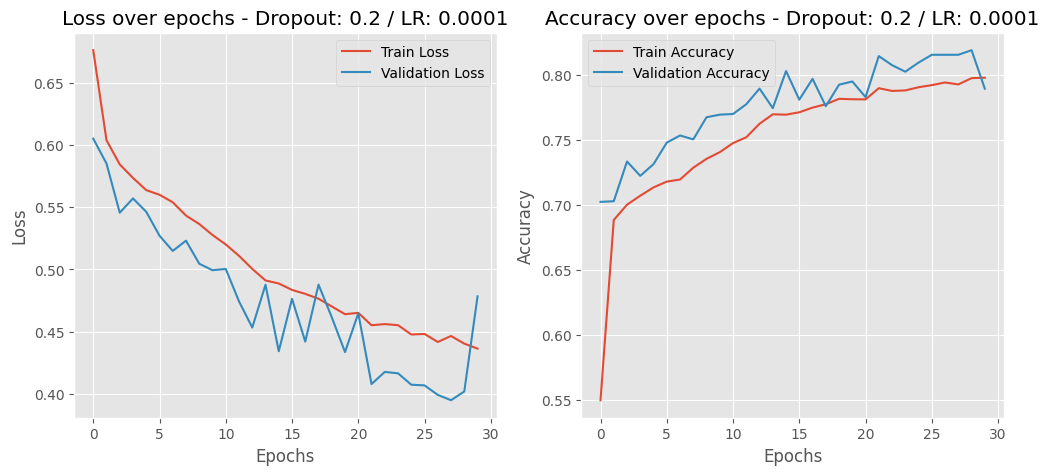

In [ ]:
model, graph = lstm_model(lr = 0.0001, epoch = 30, dropout=0.2, batch=32)


Epoch 1/30
150/150 - 22s - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6933 - val_accuracy: 0.4908 - 22s/epoch - 145ms/step
Epoch 2/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6934 - val_accuracy: 0.4908 - 19s/epoch - 128ms/step
Epoch 3/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 128ms/step
Epoch 4/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6934 - val_accuracy: 0.4908 - 19s/epoch - 127ms/step
Epoch 5/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.4908 - 19s/epoch - 128ms/step
Epoch 6/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 127ms/step
Epoch 7/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 127ms/step
Epoch 8/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 129

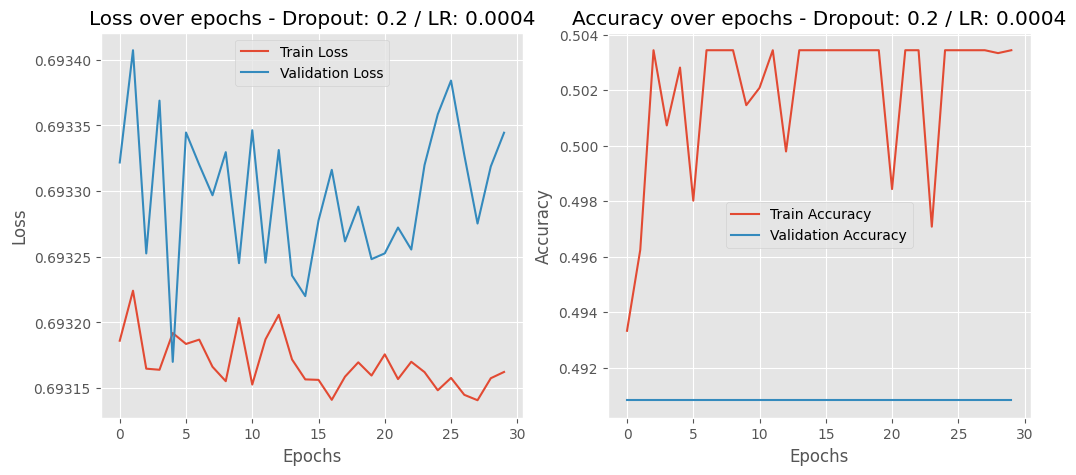

In [ ]:
model, graph = lstm_model(lr = 0.0004, epoch = 30, dropout=0.2, batch=32)

In [ ]:
graph_2

Epoch 1/30
150/150 - 21s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4908 - 21s/epoch - 142ms/step
Epoch 2/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6934 - val_accuracy: 0.4908 - 19s/epoch - 125ms/step
Epoch 3/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.4908 - 19s/epoch - 125ms/step
Epoch 4/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 125ms/step
Epoch 5/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 125ms/step
Epoch 6/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 126ms/step
Epoch 7/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4908 - 19s/epoch - 125ms/step
Epoch 8/30
150/150 - 19s - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4908 - 19s/epoch - 125

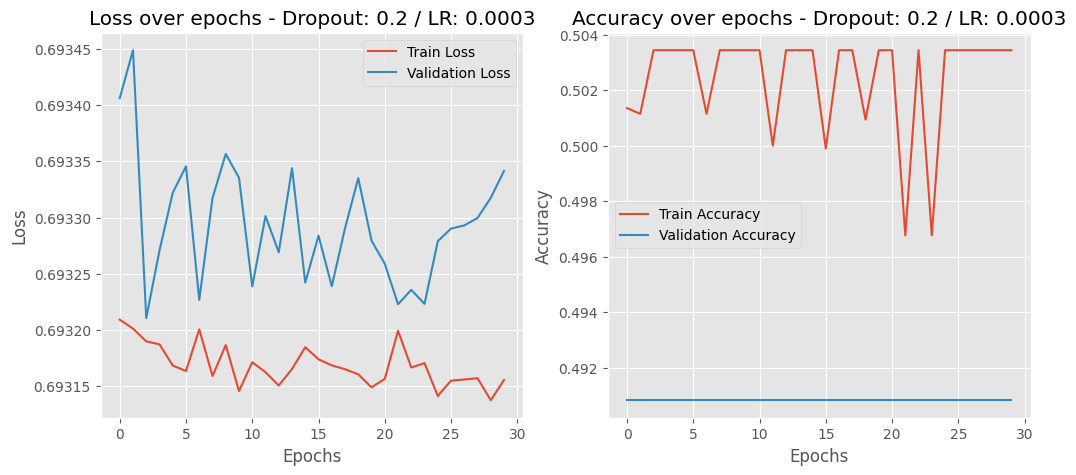

In [ ]:
model_3, graph_3 = lstm_model(lr = 0.0003, epoch = 30, dropout=0.2, batch=64)

In [ ]:
graph_3

### Fixing Stop Words

Epoch 1/30
563/563 - 122s - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5080 - 122s/epoch - 217ms/step
Epoch 2/30
563/563 - 119s - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5080 - 119s/epoch - 211ms/step
Epoch 3/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5080 - 118s/epoch - 210ms/step
Epoch 4/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5080 - 118s/epoch - 210ms/step
Epoch 5/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5080 - 118s/epoch - 210ms/step
Epoch 6/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5080 - 118s/epoch - 210ms/step
Epoch 7/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5080 - 118s/epoch - 210ms/step
Epoch 8/30
563/563 - 118s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5080 - 

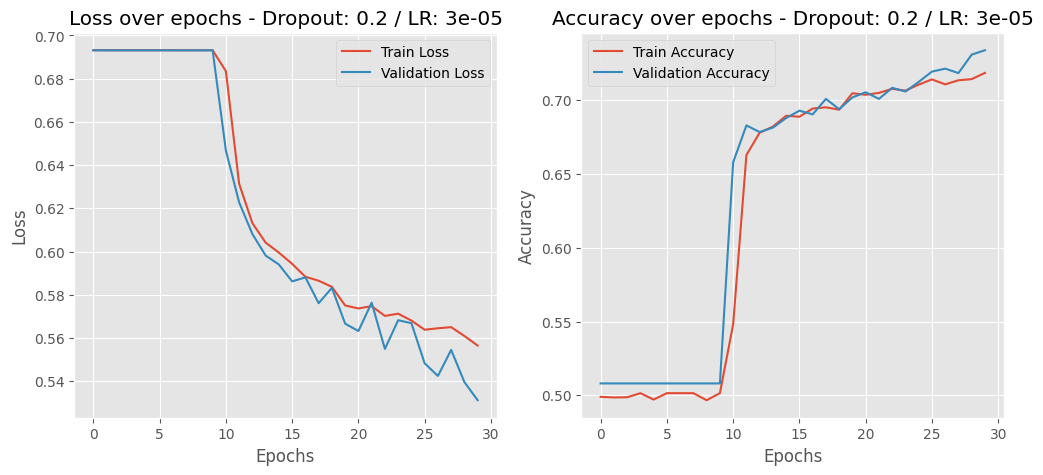

In [ ]:
model_as, graph_as = lstm_model(lr = 0.00003, epoch = 30, dropout=0.2, batch=32)

## GRU

In [24]:
def generate_model_gru(model_dir, n_words, embedding_matrix, MAX_LEN, X_train, X_test, y_train, y_test, dropout=[0.3], learning_rate=[1e-4], epoch=15, batch_size=[16]):
    models = {}
    for didx, drop in enumerate(dropout):
        for lidx, lr in enumerate(learning_rate):
          for bidx, bs in enumerate(batch_size):
            model_name = f'gru_baseline_keras_{drop}_{lr}.keras'
            print(f'Working on - {model_name}')
            model = Sequential()
            model.add(Embedding(n_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False))
            model.add(SpatialDropout1D(drop))
            model.add(GRU(128, dropout=drop))
            model.add(Dense(1, activation='sigmoid'))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

            history = model.fit(X_train, y_train, batch_size=bs, epochs=epoch, validation_data=(X_test, y_test), verbose=2)

            model.save(f'{model_dir}/{model_name}')
            models[(drop, lr, bs)] = {'model_name': model_name, 'model_results': history, 'dropout': drop, 'lr': lr, 'batch_size': bs}

    return models

## Before Stop Words

In [ ]:
model_gru = generate_model_gru(dropout=[0.2,0.1], learning_rate=[ 1e-5], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test, epoch=15,batch_size=4 )

Working on - gru_baseline_keras_0.2_1e-05.keras
Epoch 1/15
4500/4500 - 24s - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4885 - 24s/epoch - 5ms/step
Epoch 2/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 3/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 4/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 5/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 6/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 7/15
4500/4500 - 23s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 23s/epoch - 5ms/step
Epoch 8/15
4500/4500 - 23s - loss: 0.6932 - accuracy: 0.5023 - val_los

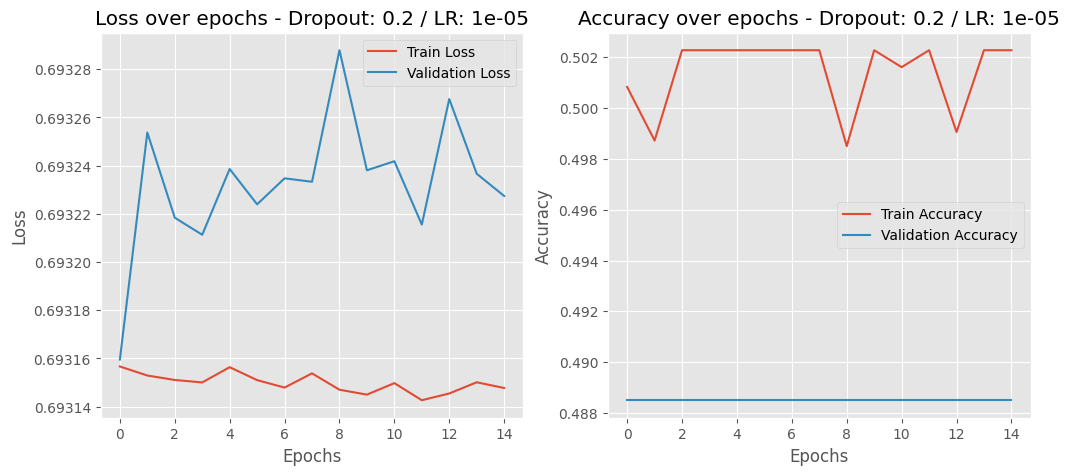

In [ ]:
plot_img(model_gru[(0.2, 1e-05)]['model_results'], drop=0.2, lr=1e-05)

In [ ]:
 model_gru_2 = generate_model_gru(dropout=[0.2], learning_rate=[ 1e-4], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test, epoch=30,batch_size=16)

Working on - gru_baseline_keras_0.2_0.0001.keras
Epoch 1/30
1125/1125 - 8s - loss: 0.6933 - accuracy: 0.4967 - val_loss: 0.6933 - val_accuracy: 0.4885 - 8s/epoch - 7ms/step
Epoch 2/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5115 - 6s/epoch - 5ms/step
Epoch 3/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4885 - 6s/epoch - 5ms/step
Epoch 4/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4885 - 6s/epoch - 5ms/step
Epoch 5/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4885 - 6s/epoch - 5ms/step
Epoch 6/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6935 - val_accuracy: 0.4885 - 6s/epoch - 5ms/step
Epoch 7/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6933 - val_accuracy: 0.4885 - 6s/epoch - 5ms/step
Epoch 8/30
1125/1125 - 6s - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6934 - va

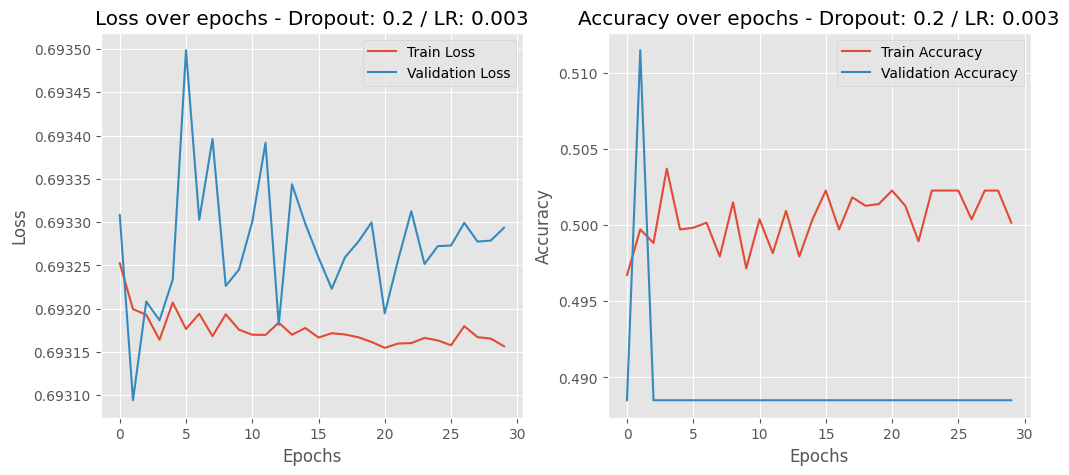

In [ ]:
plot_img(model_gru_2[(0.2, 0.0001)]['model_results'], drop=0.2, lr=3e-3)

In [ ]:
 model_gru_3 = generate_model_gru(dropout=[0.2], learning_rate=[ 1e-4], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test, epoch=30,batch_size=128)

Working on - gru_baseline_keras_0.2_0.0001.keras
Epoch 1/30
141/141 - 3s - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6933 - val_accuracy: 0.4885 - 3s/epoch - 23ms/step
Epoch 2/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6933 - val_accuracy: 0.4885 - 989ms/epoch - 7ms/step
Epoch 3/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 993ms/epoch - 7ms/step
Epoch 4/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6933 - val_accuracy: 0.4885 - 990ms/epoch - 7ms/step
Epoch 5/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6934 - val_accuracy: 0.4885 - 993ms/epoch - 7ms/step
Epoch 6/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4885 - 993ms/epoch - 7ms/step
Epoch 7/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4885 - 994ms/epoch - 7ms/step
Epoch 8/30
141/141 - 1s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 -

In [ ]:
 model_gru_4 = generate_model_gru(dropout=[0.1], learning_rate=[ 0.00001], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test, epoch=60,batch_size=64)

Working on - gru_baseline_keras_0.1_1e-05.keras
Epoch 1/60
282/282 - 4s - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4885 - 4s/epoch - 13ms/step
Epoch 2/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 3/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 4/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 5/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 6/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 7/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4885 - 2s/epoch - 6ms/step
Epoch 8/60
282/282 - 2s - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.48

## After Stop Words

After we had figured out that we needed to make sure that the stop words have been clearly removed; we shall see that there is less

Working on - gru_baseline_keras_0.3_0.002.keras
Epoch 1/30
2000/2000 - 12s - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5050 - 12s/epoch - 6ms/step
Epoch 2/30
2000/2000 - 11s - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5050 - 11s/epoch - 5ms/step
Epoch 3/30
2000/2000 - 10s - loss: 0.6934 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4950 - 10s/epoch - 5ms/step
Epoch 4/30
2000/2000 - 10s - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5050 - 10s/epoch - 5ms/step
Epoch 5/30
2000/2000 - 11s - loss: 0.6935 - accuracy: 0.5071 - val_loss: 0.6934 - val_accuracy: 0.4950 - 11s/epoch - 5ms/step
Epoch 6/30
2000/2000 - 11s - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6934 - val_accuracy: 0.5050 - 11s/epoch - 5ms/step
Epoch 7/30
2000/2000 - 11s - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4950 - 11s/epoch - 5ms/step
Epoch 8/30
2000/2000 - 11s - loss: 0.6933 - accuracy: 0.5001 - val_los

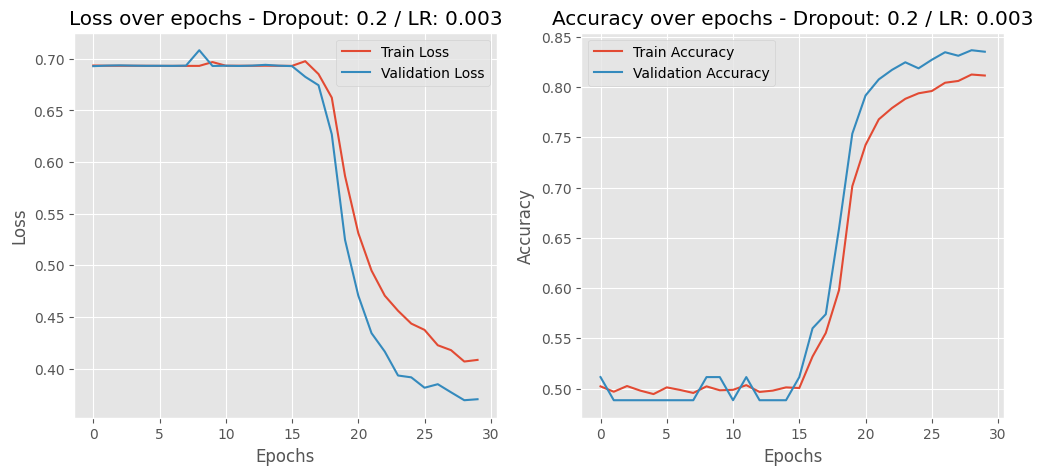

In [ ]:
plot_img(model_gru_sw[(0.2, 0.003)]['model_results'], drop=0.2, lr=3e-3)

### Double Checking

In order to run a specific text through the model you would want to do something of this nature.

In [ ]:
model_name = '20240427_balanced_0.0001_epoch_45.keras'
model.save(f'/content/drive/MyDrive/MSDS Deep Learning/{model_name}')

In [ ]:
from keras.preprocessing.sequence import pad_sequences
text_to_predict = []
pred = []
for i in range(10):
  text = data.iloc[i]['text']
  cat = data.iloc[i]['category']
  text_to_predict.append( text)
  sequences = tokenizer_obj.texts_to_sequences(text_to_predict)
  padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)
  predictions = model.predict(padded_sequences)
  print(f'{i}: category: {cat} - {text} pred - {predictions[i]}')



1/1 [==============================] - 0s 65ms/step
0: category: 0 - Entitled obnoxious defensive lying weasel This thing is to make decisions that may affect my life He is a women hater    pred - [0.39418933]
1/1 [==============================] - 0s 43ms/step
1: category: 0 - Thank you  and  for what you did for the women and survivors this week  
 pred - [0.33509126]
1/1 [==============================] - 0s 41ms/step
2: category: 0 - Knitting s amp getting ready for January 19 2019      pred - [0.31650913]
1/1 [==============================] - 0s 42ms/step
3: category: 1 - Yep just like triffeling women weaponized their poon Wonder if Kamala Harris ever extorted Willy Brown after throwing the poon on him oh yeh that how she got her first job me too is a JOKE  pred - [0.74771756]
1/1 [==============================] - 0s 43ms/step
4: category: 0 - No the President wants to end  movement posing  as the  movement pred - [0.2526919]
1/1 [==============================] - 0s 43ms/step


In [ ]:
predictions

array([[0.14013885],
       [0.13124573],
       [0.10781718],
       [0.18538128],
       [0.12217933],
       [0.13403757],
       [0.1356121 ],
       [0.14997795],
       [0.13344684],
       [0.14713962]], dtype=float32)

# Results / Analysis

| Model | Learning Rate | Epoch | Dropout | Batch | Validation Accuracy |
|---|---|---|---|---|---|
| LSTM w/ Stop Words | 0.0001 | 30 | 0.2 | 32 | 0.819 |
| LSTM w/ Stop Words | 0.0004 | 30 | 0.2 | 32 | 0.4908 |
| LSTM w/ Stop Words | 0.0003 | 30 | 0.2 | 64 | 0.4908 |
| LSTM w/o Stop Words | 0.00003 | 30 | 0.2 | 32 | 0.7340 |
| GRU w/ Stop Words| 0.00002 | 4 | 0.2 | 15 | 0.4885 |
| GRU w/ Stop Words | 0.00002 | 4 | 0.1 | 15 | 0.4885 |
| GRU w/ Stop Words | 0.0004 | 4 | 0.2 | 30 | 0.4885 |
| GRU w/ Stop Words | 0.00001 | 60 | 0.2 |64 | 0.4885 |
| GRU w/o Stop Words | 0.00001 | 30 | 0.3 |32 | 0.7780 |

### Results and Analysis of LSTM and GRU Models

In this comparative analysis, we examined the performance of LSTM and GRU models under varying configurations to understand how changes in parameters such as learning rate, dropout, batch size, and the inclusion of stop words affect model performance, specifically in terms of validation accuracy.

#### LSTM Models Analysis:
1. **With Stop Words**:
   - The LSTM model with a learning rate of 0.0001, batch size of 32, and dropout of 0.2 achieved the highest validation accuracy of 81.9% after 30 epochs. This indicates that a moderate learning rate coupled with standard dropout and batch size settings can effectively capture dependencies in data inclusive of stop words.
   - Increasing the learning rate to 0.0004, whether maintaining the batch size (32) or increasing it to 64, resulted in significantly lower validation accuracies of around 49.08%. This suggests that higher learning rates might lead to unstable training or insufficient learning in this specific context.

2. **Without Stop Words**:
   - The model exhibited a validation accuracy of 73.4% with a very low learning rate of 0.00003, suggesting that reducing noise by excluding stop words might require finer adjustments in learning rate to capture the more subtle nuances in the data.

#### GRU Models Analysis:
1. **With Stop Words**:
   - Across various settings, the GRU models with stop words consistently showed low validation accuracies around 48.85%, regardless of adjustments in learning rate, dropout, or batch size. This consistent underperformance might indicate issues with the model's ability to manage noise introduced by stop words or possibly insufficient epochs for convergence, especially considering the variability in epochs and batch sizes.
   
2. **Without Stop Words**:
   - Removing stop words improved the GRU model's performance significantly, achieving a validation accuracy of 77.8% with a low learning rate of 0.00001 and a higher dropout of 0.3. This suggests that GRU models might be particularly sensitive to the quality of input data and can perform better with cleaner, less noisy data.

#### Summary:
- **LSTM vs. GRU**: LSTMs generally outperformed GRUs in configurations with stop words, achieving the highest accuracy of 81.9% compared to GRUs' best of 77.8% without stop words. This might imply that LSTMs are better suited for handling sequences with more complex dependencies or noise.
- **Impact of Stop Words**: Both LSTM and GRU models showed varied performance impacts with the inclusion of stop words. While LSTMs could still perform reasonably well with stop words, GRUs showed significant performance enhancements only when stop words were removed.
- **Sensitivity to Learning Rate and Epochs**: Both models were sensitive to the learning rate, but LSTMs showed some resilience at moderate rates. GRUs did not benefit from higher epochs in configurations with stop words, possibly indicating a need for longer training periods or tweaking other parameters more effectively.

This analysis highlights the importance of tuning model parameters carefully based on the characteristics of the input data and the specific requirements of the model architecture. Further experiments with a broader range of epochs and a detailed examination of overfitting versus underfitting dynamics could provide deeper insights into optimizing these models.







# Conclusion

### Conclusion

The comparative study between LSTM and GRU models under various configurations highlights several critical insights and practical implications for designing and tuning neural networks for sequence processing tasks. The analysis indicates that both LSTM and GRU models exhibit distinct sensitivities to changes in learning rates, batch sizes, and the presence of stop words, which significantly impact their performance in terms of validation accuracy.

LSTMs have demonstrated a superior ability to handle sequences with higher levels of noise, as evidenced by their robust performance in configurations including stop words. With the highest recorded validation accuracy of 81.9%, LSTMs proved particularly effective at a moderate learning rate of 0.0001, coupled with standard dropout and batch size settings. This suggests that LSTMs are likely more suitable for applications where the input data includes less pre-processing or where the sequence data is inherently noisy and complex.

On the other hand, GRUs displayed increased performance sensitivity to input quality. The notable improvement in validation accuracy from 48.85% to 77.8% when stop words were removed indicates that GRUs might perform better with cleaner and less noisy data. This characteristic makes GRUs potentially more effective in scenarios where preprocessing effectively reduces input noise and complexity.

From this study, it is evident that the choice between using LSTM and GRU models should be guided by the specific requirements of the task, including the nature of the input data and the desired balance between training efficiency and model accuracy. It is also clear that fine-tuning the parameters such as learning rate, dropout, and batch size according to the model type and task can significantly enhance model performance.

Moreover, the results underline the importance of iterative testing and validation in model development. Future work should aim to explore a broader range of hyperparameters and possibly integrate techniques such as hyperparameter optimization algorithms to further refine model performance. Additionally, extending the analysis to include more complex or different types of sequence data could validate the generalizability of these findings across various domains.

### Future Work
Unfortunately class work when working a full time job can become pretty complex to balance the two. I really enjoyed the work that was involved in putting the following work together,here are a few things that I like to do.

Here's a draft for a "Future Work" section based on the provided text and bullet points:


- **Incorporate More Data**: Currently, only about 20% of the available data has been utilized for training. Expanding the dataset will likely improve the model’s performance and robustness by exposing it to a more varied set of training examples.

- **Explore Alternative Data Encoders**: While the current model uses basic encoding techniques, experimenting with other encoders such as Word2Vec or newer methods like TikToken could enhance the model’s ability to understand and process natural language more effectively.

- **Experiment with Different Model Architectures**: Testing other neural network architectures could provide insights into optimal configurations for our specific tasks. Future experiments could include Bidirectional RNNs, which process data in both forward and reverse directions, or Transformer networks, which have recently set new standards in modeling sequential data.

- **Integrate Additional Data Features**: Incorporating more diverse data features such as user count, followers, or other relevant metadata could add valuable context to the model, potentially leading to more accurate and insightful predictions.


In conclusion, this analysis not only sheds light on the operational strengths and weaknesses of LSTM and GRU networks but also serves as a foundation for more informed decisions in the selection and optimization of neural network architectures for tackling specific sequence processing challenges.